This colab notebook contain walkthrough of the set up of DNABERT-reg, and the result section 3.1 to 3.2

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
!pip install Bio

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig,AdamW , get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sb
from scipy.stats.stats import pearsonr 
import matplotlib.font_manager as fm
import matplotlib as mpl
from pylab import cm
from scipy.stats import iqr

In [ ]:
random.seed(42)

In [ ]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

Using GPU.


In [ ]:
def seq2kmer(seq, k = 4):
    """
    Function provided by Ji et al. (https://github.com/jerryji1993/DNABERT)
    Will convert given sequence into kmer.
    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    #kmers = " ".join(kmer)
    return kmer

In [ ]:
def kmer2seq(kmers):
    """
    Convert kmers to original sequence
    
    Arguments:
    kmers -- str, kmers separated by space.
    
    Returns:
    seq -- str, original sequence.
    """
    kmers_list = kmers.split(" ")
    bases = [kmer[0] for kmer in kmers_list[0:-1]]
    bases.append(kmers_list[-1])
    seq = "".join(bases)
    assert len(seq) == len(kmers_list) + len(kmers_list[0]) - 1
    return seq

In [ ]:
def tokenize(seq_kmers, labels):
  """
  package ground truth labels, kmer representation of sequence into dataset that
  is suitable to pass through model

  Argument:
  seq_kmers: kmer representation of local promoter sequence
  labels: ground truth gene expression of respective local promoter sequence

  Returns:
  dataset:tensor object that package respective local promoter sequence's 
          tokenized representation, ground truth gene expression, attention mask
  """
  input_ids = []
  attention_masks = []

  for sent in seq_kmers:
      encoded_dict = DNABERT_Tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          pad_to_max_length = False,
                          return_attention_mask = True,   # Construct attention masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      #since all sequence are same length, it will simply be all 1
      attention_masks.append(encoded_dict['attention_mask'])


  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)
  return dataset

In [ ]:
def train(model, optimizer, scheduler, epochs,       
          train_dataset, val_dataset, device, clip_value=2):
  
    model.to(device)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    training_stats = []


    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        total_train_loss = 0
        for index, batch in enumerate(train_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            #https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            
            optimizer.zero_grad()
            model.zero_grad()

            #output format can be found in https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/output#transformers.modeling_outputs.SequenceClassifierOutput
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            total_train_loss += loss.item()
            loss.backward()
        
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # Update learning rate schedule
            optimizer.step()
            scheduler.step()


        avg_train_loss = total_train_loss / len(train_dataloader)
        print("  Average training loss: {0:.2f}".format(avg_train_loss))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
        
        print("")
        print("Running Validation...")

        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():
                output = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)
            
            loss = output[0]
            # Accumulate the validation loss.
            total_eval_loss += loss.item()


        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
            }
        )
    return model, training_stats

In [ ]:
def predict(model, test_dataset, device):
  """
  use model to predict based on test_dataset, extract predictions and attention scores
  the model does not learn since it only perform the forward pass

  Arguments:
  model -- bert based model
  test_dataset -- test dataset that follows tokenize function
  device -- gpu or cpu

    
  Returns:
  preds -- predicted gene expression based on respective local promoter sequence
  true_labels -- ground truth of gene expression of local promoter sequence
  attention_scores -- [no. of sequence, no. of attention layers, max_seq_length, max_seq_length]
  sequences -- tokenized representation of local promoter sequence
  """


  batch_size = 1
  prediction_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
  # Put model in evaluation mode
  model.eval()

  #in this case all sequences are the same length
  max_seq_length = len(test_dataset[0][0]) #seq_len + 1 - kmer_size + 2 (CLS & SEP tokens)
  preds = None
  true_labels = None
  #define attention_scores shape [number of test samples, 12 heads, tokenized sequence length, tokenized sequence length]
  attention_scores = np.zeros([len(test_dataset), 12, max_seq_length, max_seq_length])
  sequences = []
  model.to(device)
  # ========================================
  #               Prediction
  # ========================================
  print("")
  print("Running Prediction...")

  for index, batch in enumerate(prediction_dataloader):
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          #b_label not required for predictions, no loss is calucalated
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, output_attentions=True)
          logits = outputs[0]
          if preds is None:
              preds = logits.detach().cpu().numpy()
          else:
              preds = np.concatenate((preds, logits.detach().cpu().numpy()), axis=0)
          if true_labels is None:
              true_labels = b_labels.detach().cpu().numpy()
          else:
              true_labels = np.concatenate((true_labels, b_labels.detach().cpu().numpy()), axis=0)
          #output last encoder layer's multiheaded attention score
          #TODO (10/02/2022): according to https://github.com/hanxiao/bert-as-service#q-why-not-the-last-hidden-layer-why-second-to-last
          #it is best to select outputs[-1][-2] instead
          attention = outputs[-1][-2].cpu().numpy()
          #0*1: 0*1 + 299, 12, 299, 299
          attention_scores[index*batch_size:index*batch_size+batch_size,:,:,:] = attention
          #attention_scores[index*batch_size:index*batch_size+len(batch[0]),:,:,:] = attention (18/02/2022 code check)
          sequences.append(b_input_ids.cpu().tolist())
  
  sequences=np.array(sequences).squeeze()


  print("")
  print("Prediction completed")

  return preds, true_labels, attention_scores, sequences


In [ ]:
def summariesallhead(attention_scores, kmer = 4):
    """
        The attention scores for each kmers to each are converted to each kmer
        to the [CLS] token ([CLS] token would have captured the entire context)

        Then the attention scores is converted into real scores which represent the
        attention scores for each nucleotide position

        Arguments:
        attention_scores -- [no. of sequence, no. of attention layers, max_seq_length, max_seq_length]
        where max_seq_length is the length of tokenized representation of local promoter sequence
        kmer -- size of kmer, default as 4

        Returns:
        scores -- attention_scores [no. of sequence, length of nucleotide representation of local promoter sequence]

    """
    #scores shape = [number of sequences, length of nucleotide sequence]
    scores = np.zeros([attention_scores.shape[0], attention_scores.shape[-1] -2 + kmer - 1])
    

    for index, attention_score in enumerate(attention_scores):
        attn_score = [] #[CLS] [4] [5]
        for i in range(1, attention_score.shape[-1]-kmer+3):
            #12 layers of multi-headed attention's position i contribution to [CLS] is summed
            #the contribution of [CLS] and [SEP] to [CLS] is ignored
            [12, 299, 299]
            #attn_score.append(float(attention_score[:,i,0].sum())) #code check 18022022
            attn_score.append(float(attention_score[:,0,i].sum()))


        #if the kmer in front has zero attention, the current kmer attention = 0
        """
        for i in range(len(attn_score)-1):
            if attn_score[i+1] == 0:
                attn_score[i] = 0
                break
        """

        #convert attention_scores for kmer position to real_scores for nucleotide position
        #both counts and real_scores has the length of input sequence in nucleotide
        counts = np.zeros([len(attn_score)+kmer-1])
        real_scores = np.zeros([len(attn_score)+kmer-1])
        for i, score in enumerate(attn_score):
            for j in range(kmer):
                #count number of times the specific position has a different kmer
                counts[i+j] += 1.0
                real_scores[i+j] += score
        real_scores = real_scores / counts
        #scaled down for numerical stability softmax
        real_scores = real_scores / np.linalg.norm(real_scores)
        scores[index] = real_scores
        

    return scores

In [ ]:
def attention_landscapes(attention_scores, legends):
    plt.figure(figsize=(20,6),facecolor="white")
    #plt.style.use('classic')
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False


    for index, attention_score in enumerate(attention_scores):
        attention_score_mean = attention_score.mean(axis=0)
        df_attention_score_mean = pd.DataFrame(data=attention_score_mean, index = range(-250, 50))
        plt.plot(df_attention_score_mean, label = legends[index])
    plt.legend()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("mean attention score", fontsize=20)
    plt.xlabel("relative position to TTS",fontsize=20)

    plt.show()

In [ ]:
def heatmapallhead(attention_scores):
    fig, ax = plt.subplots(figsize=(20, 9))
    start = 50 - len(attention_scores[0])
    df_attention_scores = pd.DataFrame(data = attention_scores, index = range(len(attention_scores)), columns = range(start, 50))
    colormap = sb.color_palette("flare", as_cmap=True)
    sb.set(font_scale=1.8)
    sb.heatmap(df_attention_scores, yticklabels=False)
    plt.ylabel("local promoter sequences")
    plt.xlabel("relative position to TTS")
    plt.show()

In [ ]:
def decode(tokenized_seqs):
    """
    convert tokenized representation of local promoter sequences back to its nucleotide
    format
    """
    seqs = None
    for tokenized_seq in tokenized_seqs:
        seq = DNABERT_Tokenizer.decode(tokenized_seq,
                                        skip_special_tokens = True
                                        )
        seq = kmer2seq(seq)
        
        if seqs is None:
            seqs = seq
        else:
            seqs = np.hstack((seqs, seq))
    return seqs

In [ ]:
def measurement_metric(predictions, true_labels, measurement):
    metric = measurement(true_labels, predictions)               
    return metric

Import input that was parsed using inputparser.ipynb

In [ ]:
final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/plant_genes_GSE181536_TPM_data/plant_genes_GSE181536_TPM_data_Root TRAP_mgd.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/plant_genes_GSE181536_TPM_data/plant_genes_GSE181536_TPM_data_shoot_trap.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/plant_genes_GSE181536_TPM_data/plant_genes_GSE181536_TPM_data_shoot_trap_mgd.csv")

#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ/hg38_msxTm_ENCFF910TAZ.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF292FVY/hg38_msxTm_ENCFF292FVY.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF597FGD/hg38_msxTm_ENCFF597FGD.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF279XTY/hg38_msxTm_ENCFF279XTY.csv")

load the pre-trained model with the desired k-mer size. The code below loads the 4-mer pretrained model

In [ ]:
cd /content/drive/MyDrive/master_thesis/models/4-new-12w-0/

/content/drive/MyDrive/master_thesis/models/4-new-12w-0


Parse sample data into pytorch object to pass through BERT trainer https://huggingface.co/transformers/custom_datasets.html https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer
https://huggingface.co/transformers/custom_datasets.html

In [ ]:
DNABERT_Tokenizer = BertTokenizer(vocab_file = "vocab.txt", config = "tokenizer_config.json")

In [ ]:
def constructdataset(final_matrix):
    """
    construct of train/test/validation dataset as input for DNABERT-reg


    Arguments:
    final_matrix: dataframe that store each local promoter sequence's characteristics.
                  for detail visit inputparser.ipynb
    train_dataset, test_dataset, val_dataset: datasets that act as input for DNABERT-reg.
                  The splitting can be replicated with the same random_state.
    """
    seq_kmers = list(map(seq2kmer, final_matrix["Sequence"].tolist()))
    dataset = tokenize(seq_kmers, final_matrix["logTPM"].tolist())
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=1)
    train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.25, random_state=1)
    return train_dataset, test_dataset, val_dataset

In [ ]:
train_dataset, test_dataset, val_dataset = constructdataset(final_matrix)

In [ ]:
print("train_dataset size = ", len(train_dataset))
print("val_dataset size = ", len(val_dataset))
print("test_dataset size = ", len(test_dataset))

train_dataset size =  3829
val_dataset size =  1277
test_dataset size =  1277


Select either pre-trained or fine-tuned model (4mer) based on goal

In [ ]:
cd /content/drive/MyDrive/master_thesis/models/4-new-12w-0/

/content/drive/MyDrive/master_thesis/models/4-new-12w-0


In [ ]:
model_config_path = "./config.json"
model_config =BertConfig.from_pretrained(model_config_path, num_labels = 1, attention_probs_dropout_prob = 0.1)

model_weight_path = "./pytorch_model.bin"
dnabert = BertForSequenceClassification.from_pretrained(model_weight_path, config = model_config)

Some weights of the model checkpoint at ./pytorch_model.bin were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pytorch_model.bin and a

Load fine-tuned model from repository

In [ ]:
cd /content/drive/MyDrive/master_thesis/models/4-new-12w-0/hg38_msxTm_ENCFF910TAZ/ft_dnabert_model_4mer_save/

/content/drive/MyDrive/master_thesis/models/4-new-12w-0/hg38_msxTm_ENCFF910TAZ/ft_dnabert_model_4mer_save


In [ ]:
DNABERT_Tokenizer = BertTokenizer(vocab_file = "vocab.txt", config = "tokenizer_config.json")

ft_model_config_path = "./config.json"
ft_model_config =BertConfig.from_pretrained(ft_model_config_path, num_labels = 1, attention_probs_dropout_prob = 0.1)

ft_model_weight_path = "./pytorch_model.bin"
ft_dnabert_model = BertForSequenceClassification.from_pretrained(ft_model_weight_path, config = ft_model_config)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(dnabert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Training parameters set up for DNABERT-reg

In [ ]:
batch_size =  16

batch_lr = {8:3e-4, 16:1e-4, 32: 5e-5, 64: 3e-5, 128: 3e-5}

optimizer = AdamW(dnabert.parameters(), lr=batch_lr[batch_size])

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, increasing training epochs has led to overfitting 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataset) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Finetuning of the pretrained model dnabert

In [ ]:
#run to train pre-trained model using train_dataloader and validation_dataloader
ft_dnabert_model, training_stats = train(dnabert, optimizer, scheduler, epochs, 
              train_dataset, val_dataset, device, clip_value=2)

plot the curve for the training statistics: training and validation loss per epoch

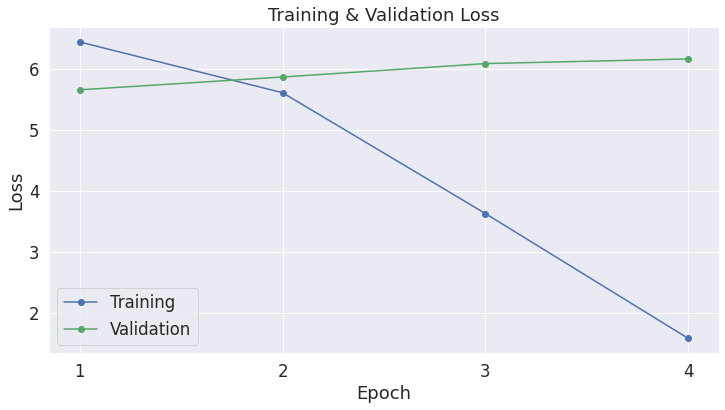

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

# Use plot styling from seaborn.
sb.set(style='darkgrid')

# Increase the plot size and font size.
sb.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, 5)))

plt.show()

Save the finetuned model in output dir

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(ft_dnabert_model, 'module') else ft_dnabert_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
DNABERT_Tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./ft_dnabert_made_up_300bp_minus23/


('./ft_dnabert_made_up_300bp_minus23/tokenizer_config.json',
 './ft_dnabert_made_up_300bp_minus23/special_tokens_map.json',
 './ft_dnabert_made_up_300bp_minus23/vocab.txt',
 './ft_dnabert_made_up_300bp_minus23/added_tokens.json')

Predictive performance of the pre-trained, finetuned and linear 4-mer model. This correspond with result section 3.1

In [ ]:
#human datasets, nrmse
ft = [0.979, 0.919, 1.005, 0.931]
pt = [18.169, 18.361, 18.495, 17.711]
kmer = [1.154, 1.067, 1.033, 1.126]

#human datasets, r-squared value
ft_r = [0.262, 0.267, 0.247, 0.277]
pt_r = [-0.349, -0.464, -0.352, -0.387]
kmer_r = [0.023, 0.027, 0.003, -0.001]

#arabidopsis datasets, nrmse
pt_p = [23.207, 22.404,22.849]
ft_p = [2.909,2.711, 2.738]
kmer_p = [1.389, 1.276, 1.280]

#arabidopsis datasets, r-squared value

ft_p_r = [-0.937, -0.749, -0.769]
pt_p_r = [-1.398, -1.373, -1.381]
kmer_p_r = [0.043, 0.094, 0.094]

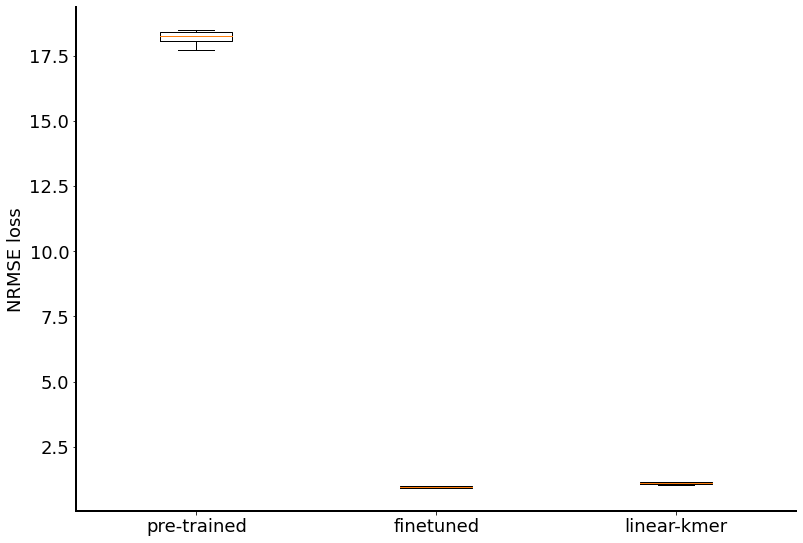

In [ ]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from pylab import cm

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

colors = cm.get_cmap('tab10', 2)


data = [pt, ft, kmer]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
 
# Creating plot
bp = ax.boxplot(data)

ax.set_ylabel("NRMSE loss")
#ax.set_ylabel("R-squared value")


ax.set_xticklabels(['pre-trained', 'finetuned', 'linear-kmer'])
 
# show plot
plt.show()

# Predictions section

The following sections involve analysis of the pre-trained and finetuned model's attention scores for the test local promoter sequences. This correspond with result section 3.2


Running Prediction...

Prediction completed


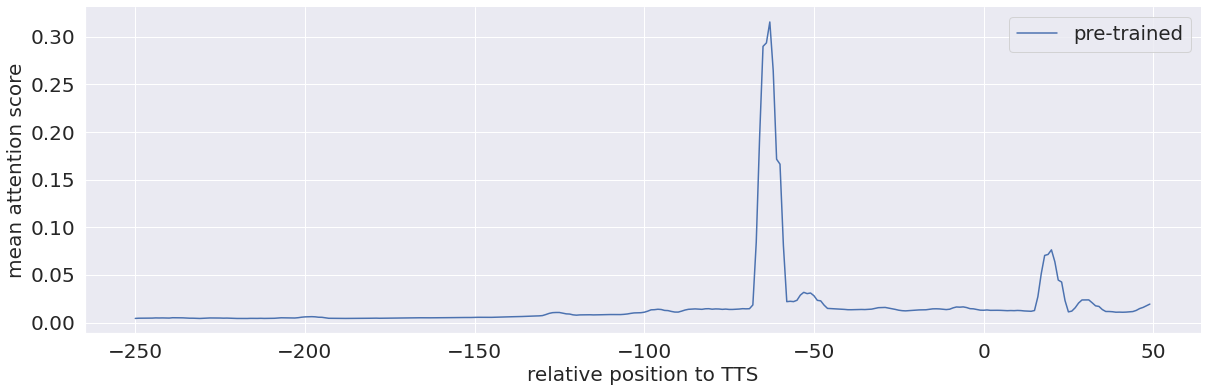

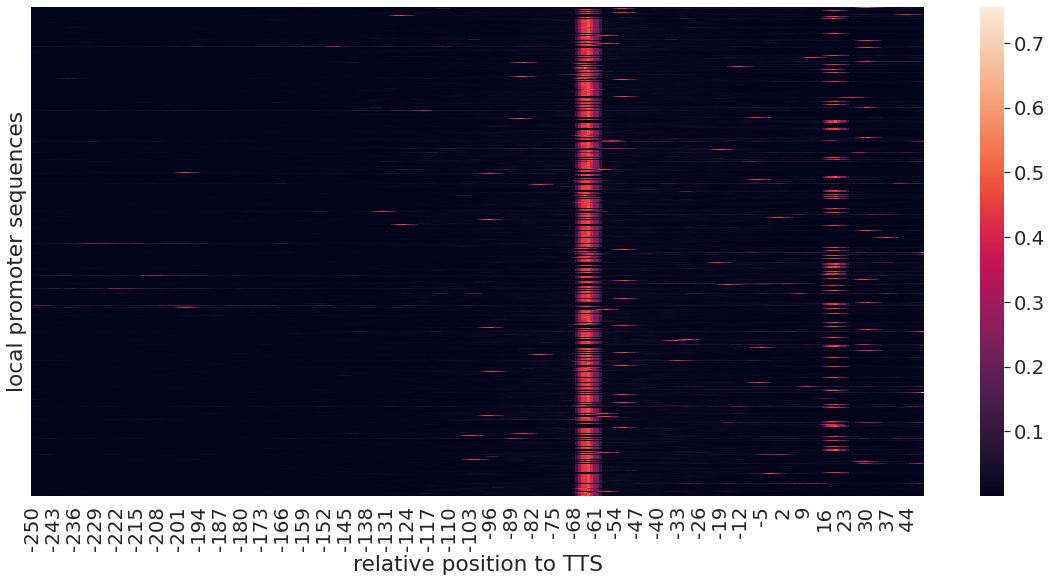

23.2072117259885 -1.397530623159931


In [ ]:
#generate prediction for pretrained model
predictions_pt, labels_pt, attention_scores_pt, sequences_pt = predict(dnabert, test_dataset, device)
att_summary_pt = summariesallhead(attention_scores_pt)
attention_landscapes([att_summary_pt], ["pre-trained"])
heatmapallhead(att_summary_pt)
mse = measurement_metric(predictions_pt, labels_pt, mean_squared_error)
normalized_rmse = np.sqrt(mse) / iqr(predictions_pt)
r2 = measurement_metric(predictions_pt, labels_pt, r2_score)
print(normalized_rmse, r2)


Running Prediction...

Prediction completed


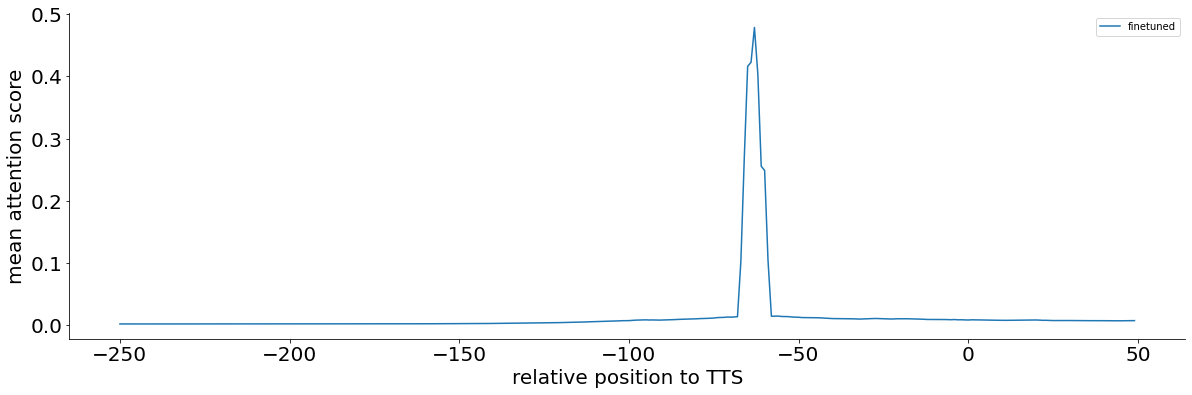

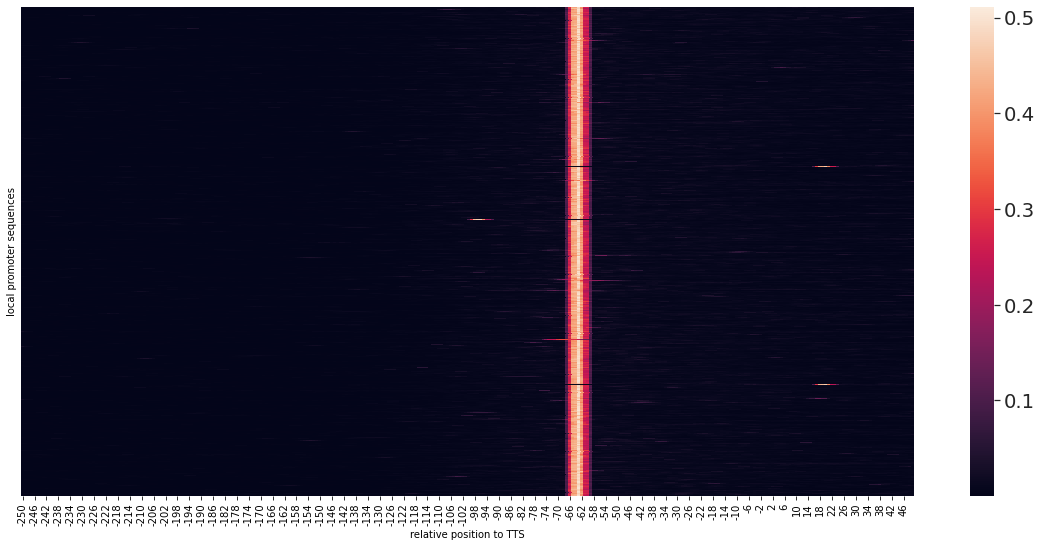

2.7108263657881713 -0.7489472865107352


In [ ]:
#generate prediction for finetuned model
predictions_ft, labels_ft, attention_scores_ft, sequences_ft = predict(ft_dnabert_model, test_dataset, device)
att_summary_ft = summariesallhead(attention_scores_ft)
attention_landscapes([att_summary_ft], ["finetuned"])
heatmapallhead(att_summary_ft)
mse = measurement_metric(predictions_ft, labels_ft, mean_squared_error)
normalized_rmse = np.sqrt(mse) / iqr(predictions_ft)
r2 = measurement_metric(predictions_ft, labels_ft, r2_score)
print(normalized_rmse, r2)

Comparison of attention landscape of pretrained and finetuned DNABERT-reg, we can see that the average attention scores for the finetuned model at position -67 to -59 region relative to TTS is significantly higher in the finetuned model

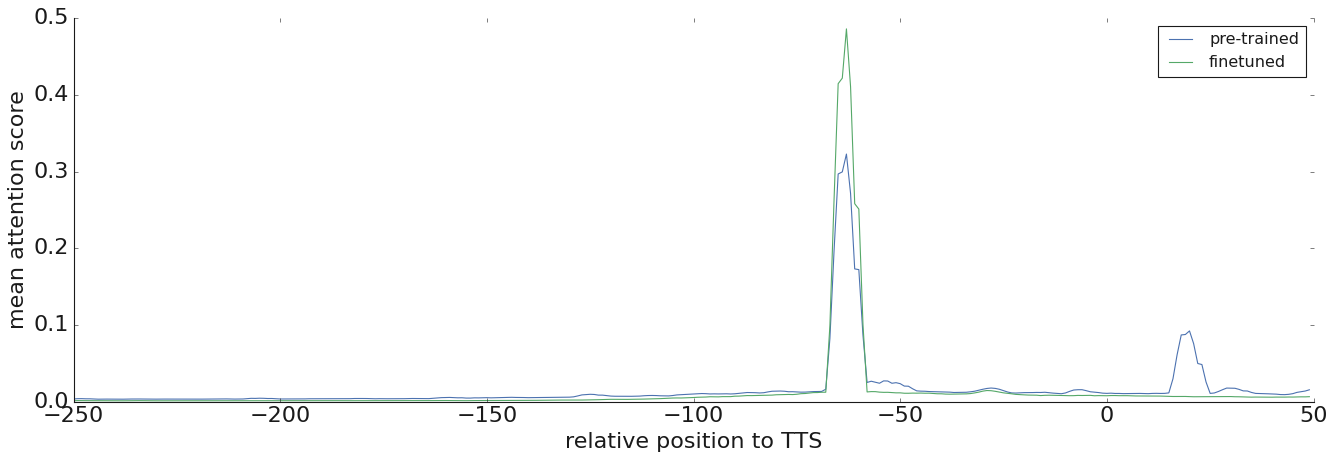

In [ ]:
attention_landscapes([att_summary_pt, att_summary_ft], ["pre-trained", "finetuned"])

When inspecting the attention heatmap for the finetuned model at position -67 to -59 region relative to TTS in close detail, we can see that individual sequence attend differently based on the contextual information at the position (sub-sequence structre)

In [ ]:
plt.figure(figsize=(30,100),facecolor="white")
start, stop = 183, 192
att_summary_subset = att_summary_ft[:, start:stop]
df_attention_scores = pd.DataFrame(data = att_summary_subset, index = range(len(att_summary_subset)), columns = range(-67, -58))
sb.heatmap(df_attention_scores)
sb.set(font_scale=10)
plt.ylabel("local promoter sequences")
plt.xlabel("relative position to TTS")
plt.show()

The local promoter sequences are binned into subsets based on their attention peak. This part correspond with result section 3.2.2

In [ ]:
subset_50 = []
subset_45_50 = []
subset_40_45 = []
subset_40 = []
for i in range(att_summary_ft.shape[0]):
    peak = max(att_summary_ft[i][183:191])
    if peak > 0.5:
        subset_50.append(i)
    elif 0.45 < peak <= 0.5:
        subset_45_50.append(i)
    elif 0.4 < peak <= 0.45:
        subset_40_45.append(i)
    elif peak <= 0.4:
        subset_40.append(i)
    else:
        print("missing", i)

In [ ]:
print(len(subset_50))
print(len(subset_45_50))
print(len(subset_40_45))
print(len(subset_40))

In [ ]:
def createmotiflogos(positive_seqs, start, end):
    """
    compute the consensus sequence and the position weighted matrix

    Arguments:
    positive_seqs: local promoter sequence of choice
    start: start position relative to the TTS of the sub-sequence
    end: end position relative to the TTS of the sub-sequence
    """
    from Bio import motifs
    from Bio.Seq import Seq
    print("start: ", start, "end: ", end)
    start += 250
    end += 250        
    seqs = [Seq(seq[start:end]) for seq in positive_seqs]
    m = motifs.create(seqs)
    print(m.consensus)
    print(m.pwm)
    print("\n")
    
    return m.consensus, m.pwm

In [ ]:
subsets = [subset_50, subset_45_50, subset_40_45, subset_40]

subset_seqs = []
for i in subsets:
    subset_seqs.append(decode(sequences_ft[i]))

In [ ]:
#generate the sub-sequences within range -67 to -59 relative to TTS in subset_50
range = [183, 191]
length = 0
start, stop = int(range[0]-length), int(range[1] + length)
att_summary_ft
for att, seq in zip(att_summary_ft, decode(sequences_ft)):
    #print(">" + str(att[187]))
    print(seq[start:stop], "\n")

0.5025789554317653
0.4858762265945276
0.4407902908178179
0.3165839051303292


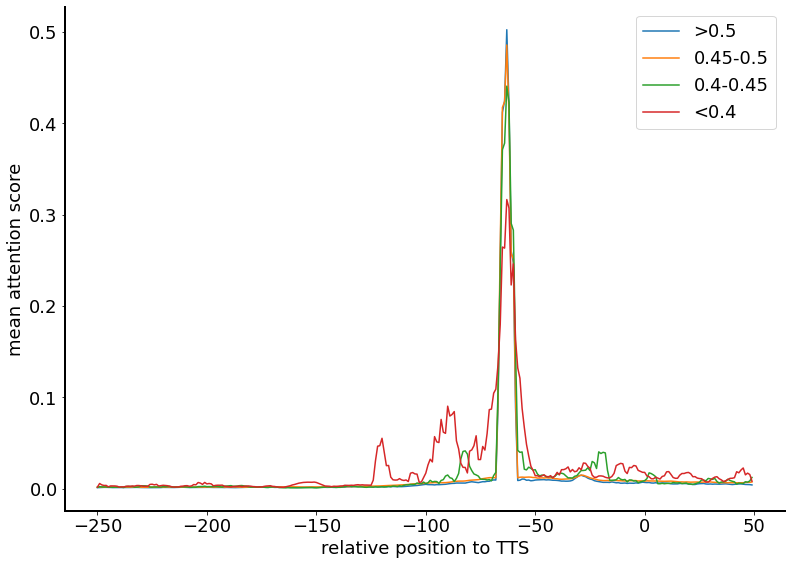

In [ ]:
subsets_names = [">0.5", "0.45-0.5", "0.4-0.45", "<0.4"]
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

colors = cm.get_cmap('tab10', 2)

 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for index, i in enumerate(subsets):
    attention_scores_mean = att_summary_ft[i].mean(axis=0)
    print(np.amax(attention_scores_mean))
    plt.plot(pd.DataFrame(data=attention_scores_mean, index = range(-250, 50)), label = subsets_names[index])


plt.ylabel("mean attention score")
plt.xlabel("relative position to TTS")
plt.legend()
plt.show()

In [ ]:
#This is connected to table 1 of the paper
consensus_seqs = []
pwms = []
for i in subset_seqs:
    consensus, pwm = createmotiflogos(i, -67, -59)
    consensus_seqs.append(consensus)
    pwms.append(pwm)